In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import itertools
import math
import hashlib
import matplotlib.cm as cm


In [12]:
# ---------- 1. Catálogos ----------
MARKERS = ['o', 's', 'D', '^', 'v', 'P', 'X', '*', 'h', '8', 'd', 'H',
           '<', '>', 'p', '1', '2', '3', '4']           # 18
COLORS = [cm.get_cmap("tab20")(i) for i in range(20)]  

# ---------- 2. Nueva asignación determinista ----------
def pick_marker_color(model_name: str) -> tuple[str, str]:
    """
    Devuelve (marker, color) únicos para el modelo mientras
    el nº de modelos ≤ len(MARKERS)*len(COLORS).
    """
    h = int(hashlib.sha256(model_name.encode()).hexdigest(), 16)
    combo = h % (len(MARKERS) * len(COLORS))   # 0 … 179

    marker = MARKERS[ combo % len(MARKERS) ]           # posición dentro de MARKERS
    color  = COLORS [ combo // len(MARKERS) ]          # grupo de 18 en 18 → color
    return marker, color


/tmp/ipykernel_48201/2574364198.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  COLORS = [cm.get_cmap("tab20")(i) for i in range(20)]


In [13]:
def plot_model_performance(
    df,
    model_col='model',
    score_col='bertscore_f1',
    size_col=None,
    parse_size=True,
    figsize=(8, 6),
    title='',
    threshold_lines=None,
    annotate_top_n=0,
):
    """
    Dibuja un diagrama de dispersión rendimiento-vs-tamaño con
    marcador y color fijos por modelo (hash determinista).
    """
    data = df.copy()

    # A) Tamaño del modelo (B) ------------------------------------------------
    if size_col is None:
        if not parse_size:
            raise ValueError("Debes proporcionar size_col o activar parse_size=True")
        def _extract_size_b(text):
            m = re.search(r'(\d+(?:\.\d+)?)([BbMm])', text)
            if m:
                num  = float(m.group(1))
                unit = m.group(2).lower()
                return num / 1_000 if unit == 'm' else num   # M → B
            return math.nan
        data['_size_B'] = data[model_col].apply(_extract_size_b)
        size_col = '_size_B'

    # B) Gráfico --------------------------------------------------------------
    fig, ax = plt.subplots(figsize=figsize)

    for _, row in data.iterrows():
        model = row[model_col]
        marker, color = pick_marker_color(model)

        ax.scatter(
            row[size_col],
            row[score_col],
            marker=marker,
            color=color,
            s=80,
            edgecolor='black',
            linewidth=0.5,
            label=model,
        )

    # C) Líneas de referencia -------------------------------------------------
    if threshold_lines:
        for y_val, style_kwargs in threshold_lines:
            kwargs = {"linestyle": "--", "linewidth": 1}
            if style_kwargs:
                kwargs.update(style_kwargs)
            ax.axhline(y=y_val, **kwargs)

    # D) Anotar los top-n ------------------------------------------------------
    if annotate_top_n > 0:
        top_rows = data.nlargest(annotate_top_n, score_col)
        for _, row in top_rows.iterrows():
            ax.annotate(
                row[model_col],
                xy=(row[size_col], row[score_col]),
                xytext=(4, 3),
                textcoords='offset points',
                fontsize=8,
            )

    # E) Estética -------------------------------------------------------------
    ax.set_xlabel("Model Parameter Size (B)")
    ax.set_ylabel("BertScore" if score_col == 'bertscore_f1' else "Average Score")
    if title:
        ax.set_title(title)
    ax.grid(True, linestyle="--", alpha=0.5)

    # Leyenda sin duplicados
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 0.9),
              loc="upper left")

    plt.tight_layout()
    return fig, ax

/tmp/ipykernel_48201/247243172.py:39: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('4').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/tmp/ipykernel_48201/247243172.py:39: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('1').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/tmp/ipykernel_48201/247243172.py:39: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('3').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


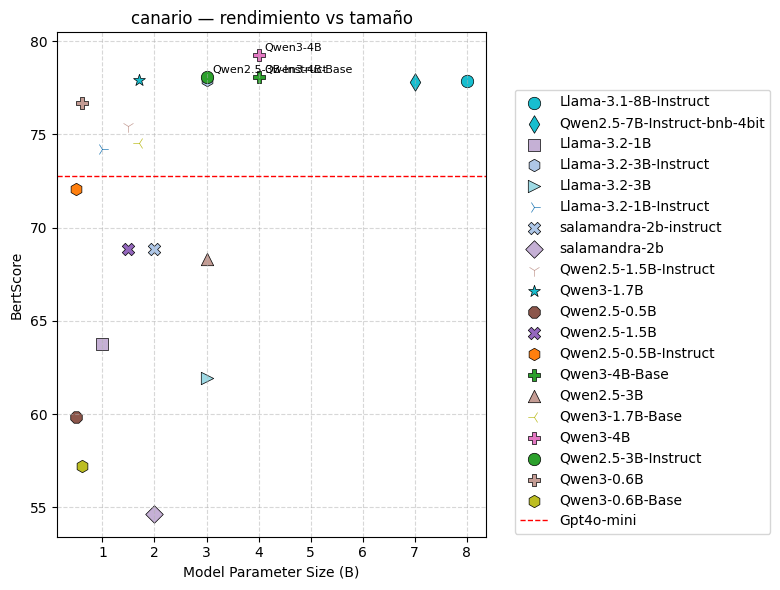

In [14]:
sheet = "canario"
df = pd.read_excel("data/metrics_summary_not_ft.xlsx", sheet_name=sheet)
score_col = "bertscore_f1"

baseline = {
    "bertscore_f1": [(72.77, {"color": "red", "label": "Gpt4o-mini"})],
    "average":      [(4.91,  {"color": "red", "label": "Gpt4o-mini"})],
}

fig, ax = plot_model_performance(
    df,
    score_col=score_col,               # o 'bertscore_f1'
    title=f"{sheet} — rendimiento vs tamaño",
    threshold_lines=baseline[score_col],
    annotate_top_n=3,
)
plt.show()

/tmp/ipykernel_48201/247243172.py:39: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('1').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/tmp/ipykernel_48201/247243172.py:39: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('3').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/tmp/ipykernel_48201/247243172.py:39: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('4').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


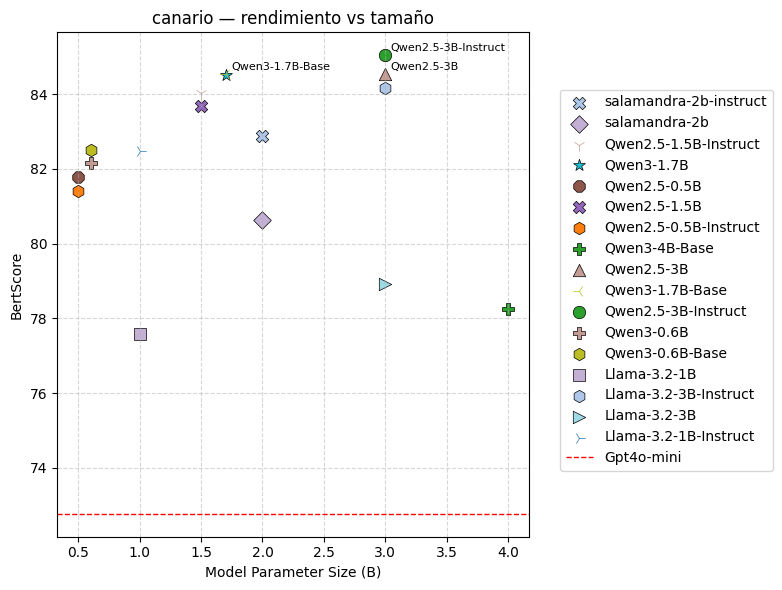

In [15]:
df = pd.read_excel("data/metrics_summary_ft.xlsx", sheet_name=sheet)
# replace name of model (ft) by ""
df['model'] = df['model'].str.replace('(ft)', '', regex=False)
# strip whitespace from model names
df['model'] = df['model'].str.strip()
fig, ax = plot_model_performance(
    df,
    score_col=score_col,               # o 'bertscore_f1'
    title=f"{sheet} — rendimiento vs tamaño",
    threshold_lines=baseline[score_col],
    annotate_top_n=3,
)
plt.show()